In [35]:
import kagglehub
wonderboylu_covid_19_chest_x_ray_dataset_path = kagglehub.dataset_download('wonderboylu/covid-19-chest-x-ray-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'covid-19-chest-x-ray-dataset' dataset.
Data source import complete.


In [36]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

In [37]:
c = os.path.join(wonderboylu_covid_19_chest_x_ray_dataset_path, 'COVID-19_Radiography_Dataset/COVID/images')
n = os.path.join(wonderboylu_covid_19_chest_x_ray_dataset_path, 'COVID-19_Radiography_Dataset/Normal/images')
p = os.path.join(wonderboylu_covid_19_chest_x_ray_dataset_path, 'COVID-19_Radiography_Dataset/Viral Pneumonia/images')
b = os.path.join(wonderboylu_covid_19_chest_x_ray_dataset_path, 'COVID-19_Radiography_Dataset/Bacteria/images')

In [38]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 2500) + os.listdir(p) + os.listdir(b)

### Classes
* 0 -> Normal
* 1 -> Viral Pneumonia
* 2 -> Bacteria Pneumonia
* 3 -> COVID


In [39]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(3))
    elif category == 'Bacteria':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [40]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Bacteria' in filenames[i]:
        filenames[i] = os.path.join(b, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [41]:
df.head()

,filename,category
0,/kaggle/input/covid-19-chest-x-ray-dataset/COV...,3
1,/kaggle/input/covid-19-chest-x-ray-dataset/COV...,3
2,/kaggle/input/covid-19-chest-x-ray-dataset/COV...,3
3,/kaggle/input/covid-19-chest-x-ray-dataset/COV...,3
4,/kaggle/input/covid-19-chest-x-ray-dataset/COV...,3


In [42]:
df.shape

(10233, 2)

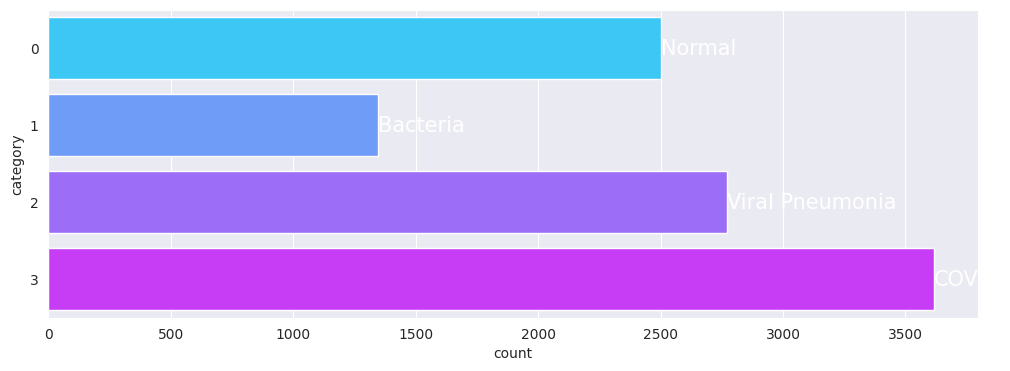

In [43]:
plt.figure(figsize=(12,4))

splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)

# Manually add labels to the bars
labels = ['Normal', 'Bacteria', 'Viral Pneumonia', 'COVID']
for i, patch in enumerate(splot.patches):
    plt.text(patch.get_width(), patch.get_y() + patch.get_height()/2, \
             labels[i], va='center', size=15, color='w')


plt.show()

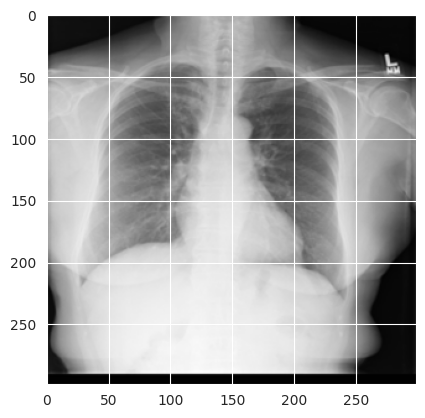

In [44]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [45]:

train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [46]:

test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [47]:

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [48]:


train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 8186 validated image filenames belonging to 4 classes.


In [49]:

valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 1024 validated image filenames belonging to 4 classes.


## Model Training - Xception

#### Model Architecture

In [50]:
engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
        #classes = 4,

    )
#GlobalAveragePooling2D
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x =tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)

out = tf.keras.layers.Dense(4, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )


model.summary()

In [51]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_36[0][0]    

 Total params: 20,877,868 (79.64 MB)

 Trainable params: 20,819,244 (79.42 MB)

 Non-trainable params: 58,624 (229.00 KB)

In [52]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [53]:

history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=50,

                        )

Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 225s 719ms/step - accuracy: 0.8184 - loss: 0.4860 - val_accuracy: 0.7832 - val_loss: 0.7650
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 159s 619ms/step - accuracy: 0.9484 - loss: 0.1451 - val_accuracy: 0.7959 - val_loss: 1.0599
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 159s 621ms/step - accuracy: 0.9496 - loss: 0.1323 - val_accuracy: 0.7969 - val_loss: 1.6104
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 159s 619ms/step - accuracy: 0.9709 - loss: 0.0755 - val_accuracy: 0.7969 - val_loss: 1.5645
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 160s 626ms/step - accuracy: 0.9730 - loss: 0.0739 - val_accuracy: 0.8350 - val_loss: 1.0351
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 159s 619ms/step - accuracy: 0.9755 - loss: 0.0674 - val_accuracy: 0.8125 - val_loss: 1.5312
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 160s 623ms/step - accuracy: 0.9777 - loss: 0.0663 - val_accuracy: 0.7383 - val_loss: 2.1389
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 159s 621ms/step - accuracy: 0.9822 -

# Final Test

In [54]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1023 validated image filenames belonging to 4 classes.


In [55]:

model.evaluate(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.8416 - loss: 0.8172


[0.7063555717468262, 0.8621701002120972]

In [56]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1)


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Normal','Bacteria','Viral Pneumonia', 'COVID'], digits=5))

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step


                 precision    recall  f1-score   support

         Normal    1.00000   0.85600   0.92241       250
       Bacteria    0.96226   0.37778   0.54255       135
Viral Pneumonia    0.67233   1.00000   0.80406       277
          COVID    0.98837   0.94183   0.96454       361

       accuracy                        0.86217      1023
      macro avg    0.90574   0.79390   0.80839      1023
   weighted avg    0.90219   0.86217   0.85510      1023



## Save Model

In [57]:
model.save('Xception.h5')

## Plotting
* Training & Validation Loss
* Training & Validation Loss

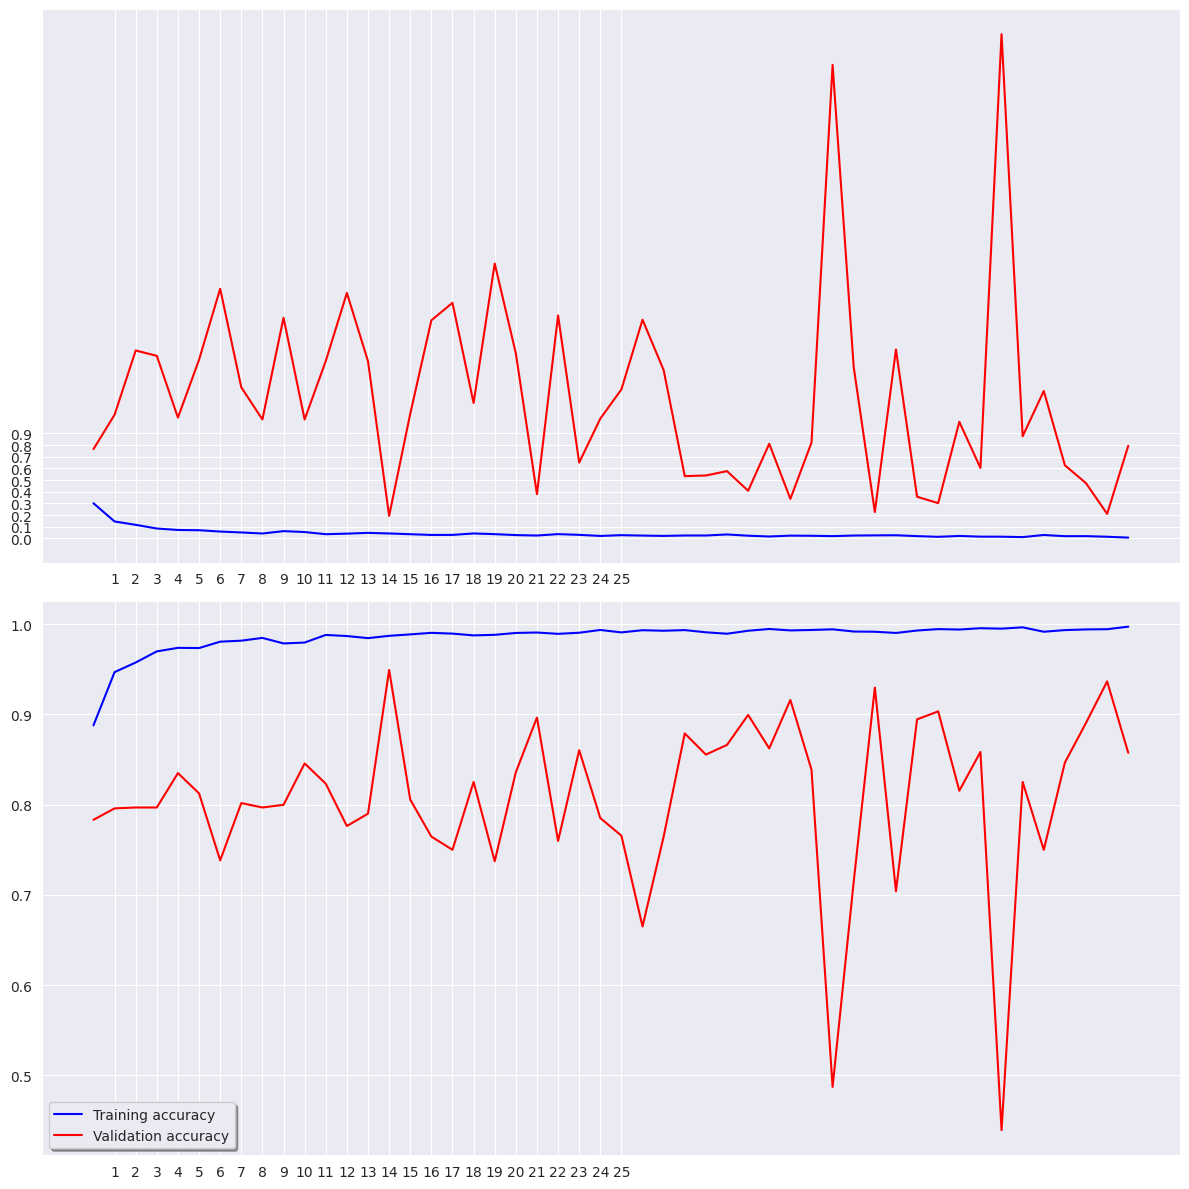

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 26, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 26, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Model Testing

True value is : Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction is:
Normal


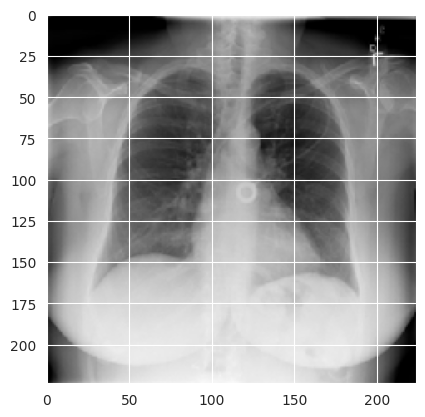

In [62]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[-1].split('-')[0].upper()
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Bacteria':
    true = 'Bacteria'
elif category == 'VIRAL PNEUMONIA':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')

image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)/255
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
elif result == 2:
    print("Bacteria")
else:
    print("COVID ")

plt.imshow(image)

In [63]:
def remap_categories(label):
    if label == 0:  # Normal
        return 0
    elif label == 1 or label == 2:  # Viral Pneumonia or Bacteria -> Pneumonia
        return 1
    elif label == 3:  # COVID
        return 2

y_true_remapped = np.array([remap_categories(l) for l in y_true])
y_pred_remapped = np.array([remap_categories(l) for l in y_pred])

print('Categories remapped successfully for true and predicted labels.')

Categories remapped successfully for true and predicted labels.


<Figure size 800x600 with 0 Axes>

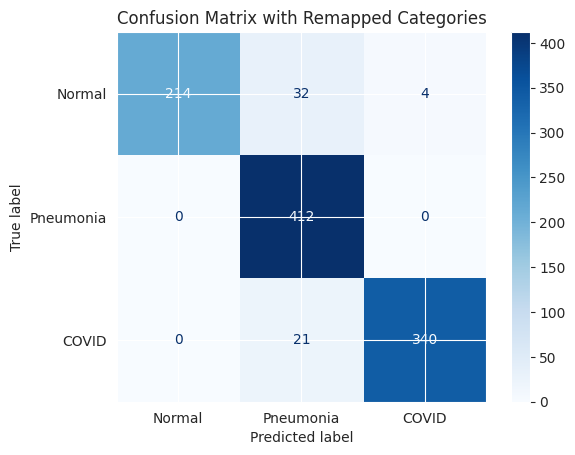

Confusion matrix for the 3-class system displayed successfully.


In [64]:
new_target_names = ['Normal', 'Pneumonia', 'COVID']

# Calculate the new confusion matrix
cm_remapped = confusion_matrix(y_true_remapped, y_pred_remapped)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_remapped, display_labels=new_target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Remapped Categories')
plt.show()

print('Confusion matrix for the 3-class system displayed successfully.')

## Final Task

### Subtask:
Provide a summary of the updated confusion matrix and its interpretation for the new 3-class categorization.
